https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

● Description of your dataset: resource, dimension, variable description, etc.

Description of Dataset: The London Bike Sharing Dataset combines bike data from Transport for London, weather data from freemeteo.com, and holiday data from the UK government website into a single dataset that can be retrieved from Kaggle. The dataset is a time-series data grouped by a timestamp field with rows delimited by hours that spans from 2015 to 2017, totaling 17414 rows. For each row (hour), the dataset has nine dimensions, including five quantitative variables and four categorical variables.
The five quantitative variables include variable “cnt” indicating the count of a new bike shares in a given hour, variable “t1” revealing the temperature in degree Celsius, variable “t2” revealing the “feels like” temperature in degree Celsius, variable “hum” giving the humidity in percentage, and variable “windspeed” displaying the wind speed in kilometers per hour. The four categorical variables contain variable “weathercode” that classifies the weather by eight types in a given hour, variable “isholiday” that flags whether the time is during a holiday or not, variable “isweekend” that flags whether the time is during a weekend or not, and variable “season” that is categorized by the four metrological season (spring, summer, fall, winter).


● Statement of the research questions, and a summary of methods being used in the analysis

The research question is to understand the different factors affecting the bike usage at a given time and to predict the future bike usage using the training dataset retrieved. The methodology is primarily based on multiple linear regression model with “cnt” being the dependent variable, but other analytics procedures will be conducted before applying the model. For example, basic exploratory data analysis on the dataset will be conducted and multiple visuals such as heatmap, bar graph, and scatter plot will be drawn to get an initial understanding among different variables. 

In addition, variance inflation factor will be tested before applying linear regression to spot for multicollinearity. Lastly, analysis of variance will be conducted.

● The explanatory data analysis may include but not limited to graphs, demographic summaries, crosstables, individual tests, etc.. And some initial findings at this point.

● Regression analysis that may include but not limited to multiple linear regression model and logistic regression model.


"timestamp" - timestamp field for grouping the data

"cnt" - the count of a new bike shares

"t1" - real temperature in C

"t2" - temperature in C "feels like"

"hum" - humidity in percentage

"windspeed" - wind speed in km/h

"weathercode" - category of the weather

"isholiday" - boolean field - 1 holiday / 0 non holiday   ##bealoon variable

"isweekend" - boolean field - 1 if the day is weekend     ##categorical variable

"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.  ##categorical variable

"weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from statsmodels.stats.diagnostic import het_breuschpagan


data = pd.read_csv("london_merged.csv")

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [3]:
data.shape
data.isnull().any()

timestamp       False
cnt             False
t1              False
t2              False
hum             False
wind_speed      False
weather_code    False
is_holiday      False
is_weekend      False
season          False
dtype: bool

In [4]:
data.sample(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
9907,2016-02-23 00:00:00,106,6.0,3.5,63.5,12.0,1.0,0.0,0.0,3.0
4440,2015-07-08 11:00:00,1209,19.0,19.0,60.0,29.0,3.0,0.0,0.0,1.0
9184,2016-01-23 13:00:00,1703,10.5,10.0,79.5,11.0,4.0,0.0,1.0,3.0
1536,2015-03-09 02:00:00,33,5.5,3.5,81.0,8.0,1.0,0.0,0.0,0.0
2577,2015-04-21 17:00:00,4148,15.5,15.5,53.5,19.5,1.0,0.0,0.0,0.0


In [5]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [6]:
sorted(data['season'].unique()),sorted(data['weather_code'].unique())

([0.0, 1.0, 2.0, 3.0], [1.0, 2.0, 3.0, 4.0, 7.0, 10.0, 26.0])

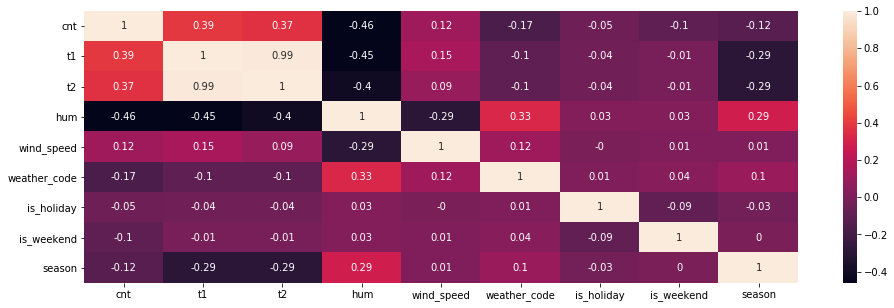

In [7]:
import seaborn as sns
correlation_matrix = data.corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)

In [8]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices('cnt~t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)', data=data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                 features
0    79.139555                Intercept
1     1.338807   C(weather_code)[T.2.0]
2     1.447794   C(weather_code)[T.3.0]
3     1.231866   C(weather_code)[T.4.0]
4     1.470471   C(weather_code)[T.7.0]
5     1.003010  C(weather_code)[T.10.0]
6     1.023318  C(weather_code)[T.26.0]
7     1.027471     C(is_holiday)[T.1.0]
8     1.017796     C(is_weekend)[T.1.0]
9     2.439167         C(season)[T.1.0]
10    1.764904         C(season)[T.2.0]
11    1.670345         C(season)[T.3.0]
12    2.611878                       t1
13    1.869471                      hum
14    1.291169               wind_speed


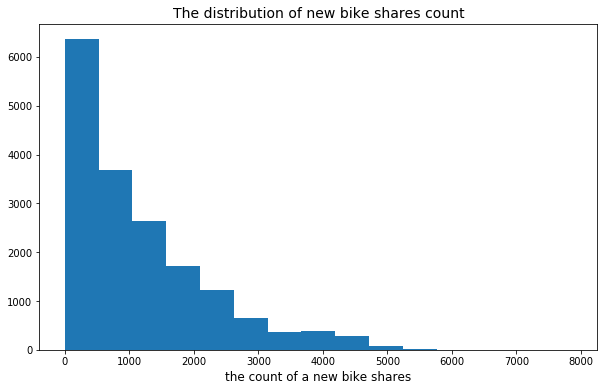

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('The distribution of new bike shares count',size=14)
ax.hist(data['cnt'],bins=15)
ax.set_xlabel("the count of a new bike shares",size=12)
plt.show()

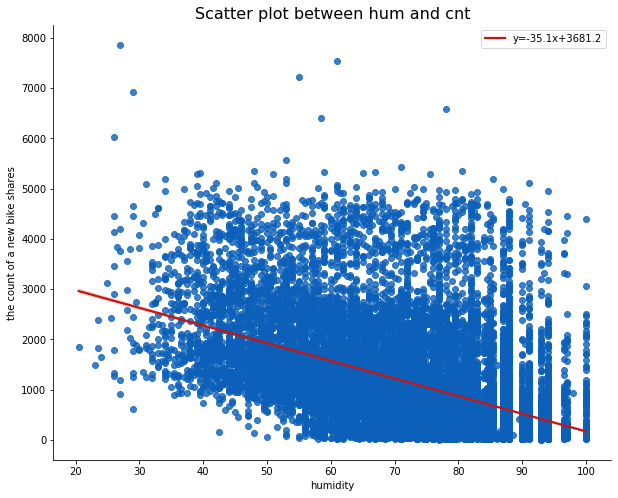

In [10]:
import seaborn as sns
from scipy import stats
plt.figure(figsize=(10,8))
slope, intercept, r_value, p_value, std_err = stats.linregress(data.hum,data.cnt)
plt.title('Scatter plot between hum and cnt',size = 16)
ax = sns.regplot(x="hum", y="cnt", data=data,scatter_kws={"color": "#0C60B9"},line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept),'color': '#C71611'})
ax.set(xlabel='humidity', ylabel='the count of a new bike shares')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

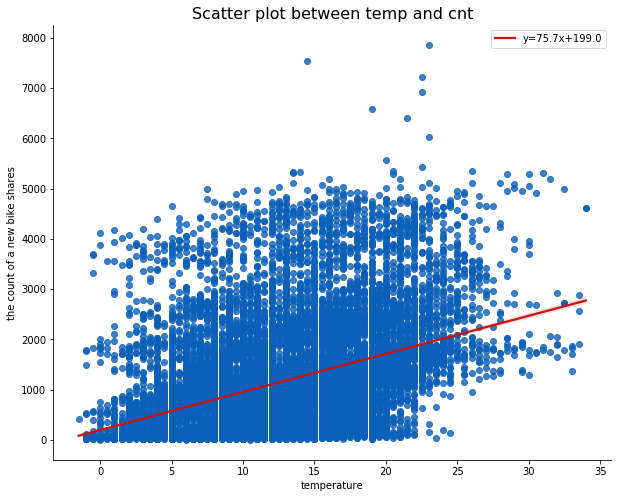

In [11]:
import seaborn as sns
from scipy import stats
plt.figure(figsize=(10,8))
slope, intercept, r_value, p_value, std_err = stats.linregress(data.t1,data.cnt)
plt.title('Scatter plot between temp and cnt',size = 16)
ax = sns.regplot(x="t1", y="cnt", data=data,scatter_kws={"color": "#0C60B9"},line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept),'color': '#C71611'})
ax.set(xlabel='temperature', ylabel='the count of a new bike shares')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

In [12]:
# delete the variable t2
# fit the model
model =smf.ols('cnt~t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)',data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     506.6
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:23:16   Log-Likelihood:            -1.4345e+05
No. Observations:               17414   AIC:                         2.869e+05
Df Residuals:                   17399   BIC:                         2.870e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2561.0622     61.680     41.522      0.000    2440.163    2681.962
C(weather_code)[T.2.0]    280.1987     19.016     14.735      0.000     242.926     317.471
C(weather_code)[T.3.0]    278.8253     20.706     13.466      0.000     238.239     319.411
C(weather_code)[T.4.0]    -97.0909     27.732     -3.501      0.000    -151.448     -42.734
C(weather_code)[T.7.0]      5.0129     25.604      0.196      0.845     -45.173      55.199
C(weather_code)[T.10.0]  -389.2944    244.998     -1.589      0.112    -869.515      90.926
C(weather_code)[T.26.0]    27.2601    119.696      0.228      0.820    -207.355     261.875
C(is_holiday)[T.1.0]     -259.2138     47.859     -5.416      0.000    -353.021    -165.406
C(is_weekend)[T.1.0]     -198.7065     15.489    -12.829      0.000    -229.066    -168.347
C(season)[T.1.0]         -123.8729     24.944     -4.966      0.000    -172.765     -74.980
C(season)[T.2.0]          113.7921     21.355      5.329      0.000      71.934     155.651
C(season)[T.3.0]          135.4103     20.732      6.532      0.000      94.774     176.047
t1                         52.8609      2.011     26.284      0.000      48.919      56.803
hum                       -28.1949      0.662    -42.568      0.000     -29.493     -26.897
wind_speed                 -7.5405      0.998     -7.556      0.000      -9.497      -5.584
==============================================================================
Omnibus:                     4812.852   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12224.414
Skew:                           1.515   Prob(JB):                         0.00
Kurtosis:                       5.768   Cond. No.                     2.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(weather_code),6.0,1.340602e+09,2.234336e+08,266.901330,0.000000e+00
C(is_holiday),1.0,4.670732e+07,4.670732e+07,55.793956,8.428578e-14
C(is_weekend),1.0,1.440971e+08,1.440971e+08,172.130387,3.887741e-39
C(season),3.0,6.951784e+08,2.317261e+08,276.807075,1.582626e-175
t1,1.0,2.168369e+09,2.168369e+09,2590.212815,0.000000e+00
hum,1.0,1.494968e+09,1.494968e+09,1785.805003,0.000000e+00
wind_speed,1.0,4.779105e+07,4.779105e+07,57.088521,4.372701e-14
Residual,17399.0,1.456539e+10,8.371395e+05,NaN,NaN


In [14]:
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,1.443262e+09,1.0,1724.040153,0.000000e+00
C(weather_code),3.656272e+08,6.0,72.792963,4.898383e-90
C(is_holiday),2.455807e+07,1.0,29.335699,6.167170e-08
C(is_weekend),1.377785e+08,1.0,164.582447,1.669304e-37
C(season),1.209438e+08,3.0,48.157573,5.504405e-31
t1,5.783403e+08,1.0,690.852925,2.371478e-149
hum,1.516944e+09,1.0,1812.056539,0.000000e+00
wind_speed,4.779105e+07,1.0,57.088521,4.372701e-14
Residual,1.456539e+10,17399.0,NaN,NaN


In [15]:
# take nature log
data['cnt_log'] = np.log(data['cnt']+1)

In [16]:
model_new =smf.ols('cnt_log~t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)',data=data).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cnt_log   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     606.0
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:23:17   Log-Likelihood:                -25588.
No. Observations:               17414   AIC:                         5.121e+04
Df Residuals:                   17399   BIC:                         5.132e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.1670      0.071    115.138      0.000       8.028       8.306
C(weather_code)[T.2.0]      0.4704      0.022     21.512      0.000       0.428       0.513
C(weather_code)[T.3.0]      0.5195      0.024     21.817      0.000       0.473       0.566
C(weather_code)[T.4.0]     -0.0921      0.032     -2.887      0.004      -0.155      -0.030
C(weather_code)[T.7.0]      0.1214      0.029      4.123      0.000       0.064       0.179
C(weather_code)[T.10.0]     0.1400      0.282      0.497      0.619      -0.412       0.692
C(weather_code)[T.26.0]    -0.6730      0.138     -4.889      0.000      -0.943      -0.403
C(is_holiday)[T.1.0]       -0.2007      0.055     -3.647      0.000      -0.309      -0.093
C(is_weekend)[T.1.0]       -0.0398      0.018     -2.233      0.026      -0.075      -0.005
C(season)[T.1.0]           -0.2171      0.029     -7.568      0.000      -0.273      -0.161
C(season)[T.2.0]            0.1806      0.025      7.353      0.000       0.132       0.229
C(season)[T.3.0]            0.2640      0.024     11.074      0.000       0.217       0.311
t1                          0.0641      0.002     27.734      0.000       0.060       0.069
hum                        -0.0371      0.001    -48.673      0.000      -0.039      -0.036
wind_speed                 -0.0067      0.001     -5.806      0.000      -0.009      -0.004
==============================================================================
Omnibus:                      310.925   Durbin-Watson:                   0.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.264
Skew:                          -0.327   Prob(JB):                     5.23e-72
Kurtosis:                       3.160   Cond. No.                     2.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

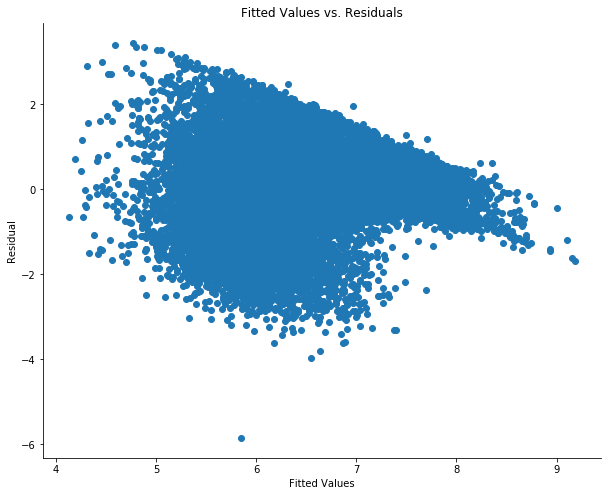

In [17]:
#Fitted Values vs. Residuals

fig, ax = plt.subplots(figsize=(10,8))

p = model_new.fittedvalues
res = model_new.resid
ax.scatter(p,res)
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residual")
ax.set_title("Fitted Values vs. Residuals")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


### Fitted Values vs. Residuals

- error term has mean 0? No. Might suggest need to transform data for a better fit.
- constant variance? No, the variance doesn't seem to be normally distributed
- indepedence? Maybe

## Influential Points

In [18]:
# Influential Points
infl = model.get_influence()

In [19]:


# fig, ax = plt.subplots(figsize=(12,12))
# fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 

In [20]:
### externally studentized residuals

n=len(data)
p=15
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
#which ones?
print(data.index[atyp_stud],reg_studs[atyp_stud])

Int64Index([   32,    56,    80,   127,   199,   223,   247,   271,   295,
              367,
            ...
            17086, 17110, 17185, 17186, 17187, 17188, 17189, 17190, 17191,
            17398],
           dtype='int64', length=972) [ 2.21744542  3.01754027  2.94647433  2.54125065  2.50477528  2.87581132
  3.15559923  2.75535629  2.22378871  3.16923721  2.09637749  4.16049038
  1.98070058  2.25745526  2.10043644  3.40088426  2.42669994  2.50323399
  3.3560484   3.33655418  2.8620244   3.47106571  2.98995483  3.4039448
  2.93725964  3.07590711  2.92971686  3.24188519  2.86701022  2.48510699
  3.67456674  3.73558487  2.08077026  2.9291503   2.08542365  2.87804678
  2.58343621  3.10229886  3.34991565  3.00933701  2.72763311  2.46205176
  3.07110527  3.41289198  2.34359723  3.17423624  3.08497774  2.9713295
  3.26685481  3.33485606  3.25646619  2.55159501  3.29491986  2.30523307
  2.01248151  3.51222769  3.89685902  3.24125657  2.71813692  2.25276859
  3.5303497   3.7534282   3.6

In [21]:
### Cook's Distance

inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(data.index[atyp_cook],reg_cook[atyp_cook])

Int64Index([   32,    56,    80,   127,   136,   199,   223,   247,   262,
              264,
            ...
            17062, 17110, 17185, 17186, 17187, 17188, 17189, 17190, 17191,
            17398],
           dtype='int64', length=744) 32       0.000231
56       0.000452
80       0.000284
127      0.000279
136      0.000230
           ...   
17188    0.001023
17189    0.000885
17190    0.000420
17191    0.000452
17398    0.000329
Name: cooks_d, Length: 744, dtype: float64


- Result: There are around 744 Influential Points in our data. However, since we do not access to additional information regarding those dataset, let's proceed for now.

## Heteroskedasticity

In [22]:
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 786.0547224922253, 'LM-Test p-value': 1.0623161944401186e-158}


- Result: P-value is <<< 0.05. Therefore, serious heteroskedasticity exists in our model
- Let's try transforming our response ( ln(y) )

### Model 2:  Ln Transformation  - ln(y)

In [23]:
data['cnt_log'] = np.log(data['cnt']+1)

In [24]:
model_log =smf.ols('cnt_log~t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)',data=data).fit()


In [25]:
bp_test = het_breuschpagan(model_log.resid, model_log.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 2326.6573198782894, 'LM-Test p-value': 0.0}


- Result: Still, heteroskedasticity exists in our model
- Let's try Robust Standard Errors 

In [26]:
#Trying Out Weighted Least Square

# data["res_sq"] = model.resid**2
# model_res = smf.ols("res_sq ~ t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)", data=data).fit()  
# weight = model_res.fittedvalues
# weight = abs(weight) 
# weight = weight**-1 
# data['weight'] = weight
# model_wls =smf.wls('cnt~t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)',data=data, weight = data['weight']).fit()
# model_wls.summary()


In [27]:
# Robuest SE
model_RSE = model.get_robustcov_results(cov_type = "HC0")
model_RSE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     533.8
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:25:01   Log-Likelihood:            -1.4345e+05
No. Observations:               17414   AIC:                         2.869e+05
Df Residuals:                   17399   BIC:                         2.870e+05
Df Model:                          14                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2561.0622     60.718     42.179      0.000    2442.048    2680.076
C(weather_code)[T.2.0]    280.1987     20.040     13.982      0.000     240.919     319.479
C(weather_code)[T.3.0]    278.8253     21.102     13.213      0.000     237.463     320.188
C(weather_code)[T.4.0]    -97.0909     24.707     -3.930      0.000    -145.520     -48.662
C(weather_code)[T.7.0]      5.0129     22.067      0.227      0.820     -38.240      48.266
C(weather_code)[T.10.0]  -389.2944     59.566     -6.536      0.000    -506.049    -272.540
C(weather_code)[T.26.0]    27.2601     67.319      0.405      0.686    -104.693     159.213
C(is_holiday)[T.1.0]     -259.2138     28.992     -8.941      0.000    -316.041    -202.387
C(is_weekend)[T.1.0]     -198.7065     12.663    -15.692      0.000    -223.528    -173.885
C(season)[T.1.0]         -123.8729     26.072     -4.751      0.000    -174.976     -72.769
C(season)[T.2.0]          113.7921     21.074      5.400      0.000      72.484     155.100
C(season)[T.3.0]          135.4103     18.700      7.241      0.000      98.757     172.064
t1                         52.8609      2.082     25.388      0.000      48.780      56.942
hum                       -28.1949      0.655    -43.044      0.000     -29.479     -26.911
wind_speed                 -7.5405      0.957     -7.881      0.000      -9.416      -5.665
==============================================================================
Omnibus:                     4812.852   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12224.414
Skew:                           1.515   Prob(JB):                         0.00
Kurtosis:                       5.768   Cond. No.                     2.69e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Since we are using Robust SE, we don't need to recheck for heteroskedasticity and we can proceed

### Normally Distributed Residuals
- QQ Plot
- JB Test


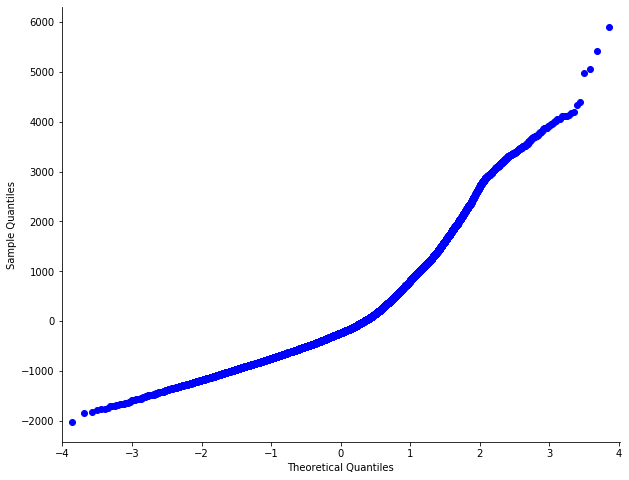

In [28]:
# QQ Plot For Model_RSE

fig, ax = plt.subplots(figsize=(10, 8))

sm.qqplot(model_RSE.resid, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

By examining QQ plot and JB testing, we can say that our residual is not normally distributed. However, since Robust SE is not sensitive to the assumption, we can proceed

## Additional Analysis: Without Influential Points

In [29]:
inf_indexes =list(data.index[atyp_cook])
len(inf_indexes)

744

In [30]:
data_wo_inf = data.drop(inf_indexes, axis=0)

In [31]:
model_wo_inf =smf.ols('cnt~t1+hum+wind_speed+C(weather_code)+C(is_holiday)+C(is_weekend)+C(season)',data=data_wo_inf).fit()
model_wo_inf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     769.7
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:25:02   Log-Likelihood:            -1.3313e+05
No. Observations:               16670   AIC:                         2.663e+05
Df Residuals:                   16655   BIC:                         2.664e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2563.6461     49.055     52.261      0.000    2467.493    2659.799
C(weather_code)[T.2.0]    292.4652     15.125     19.336      0.000     262.818     322.113
C(weather_code)[T.3.0]    274.0092     16.476     16.631      0.000     241.714     306.304
C(weather_code)[T.4.0]    -86.6287     22.016     -3.935      0.000    -129.782     -43.476
C(weather_code)[T.7.0]     86.6800     20.261      4.278      0.000      46.966     126.394
C(weather_code)[T.10.0]  -208.7489    269.255     -0.775      0.438    -736.517     319.020
C(weather_code)[T.26.0]    67.3795    101.809      0.662      0.508    -132.177     266.936
C(is_holiday)[T.1.0]     -179.3568     38.486     -4.660      0.000    -254.793    -103.921
C(is_weekend)[T.1.0]      -45.7935     12.184     -3.759      0.000     -69.675     -21.912
C(season)[T.1.0]         -150.0810     19.945     -7.525      0.000    -189.175    -110.987
C(season)[T.2.0]          107.9577     16.962      6.365      0.000      74.710     141.205
C(season)[T.3.0]          157.1856     16.434      9.564      0.000     124.972     189.399
t1                         50.0331      1.616     30.955      0.000      46.865      53.201
hum                       -30.2018      0.527    -57.339      0.000     -31.234     -29.169
wind_speed                 -7.4270      0.793     -9.365      0.000      -8.982      -5.872
==============================================================================
Omnibus:                     2326.807   Durbin-Watson:                   0.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3478.914
Skew:                           1.026   Prob(JB):                         0.00
Kurtosis:                       3.895   Cond. No.                     3.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Summary Result (No Robust SE)
- R^2 increased by ~0.1
- Omnibus, Skewness, Kurtosis, JB test score dropped

In [32]:
model_RSE = model_wo_inf.get_robustcov_results(cov_type = "HC0")
model_RSE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     769.1
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:25:02   Log-Likelihood:            -1.3313e+05
No. Observations:               16670   AIC:                         2.663e+05
Df Residuals:                   16655   BIC:                         2.664e+05
Df Model:                          14                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2563.6461     49.390     51.906      0.000    2466.837    2660.455
C(weather_code)[T.2.0]    292.4652     16.149     18.110      0.000     260.811     324.120
C(weather_code)[T.3.0]    274.0092     16.566     16.541      0.000     241.539     306.479
C(weather_code)[T.4.0]    -86.6287     18.859     -4.593      0.000    -123.595     -49.662
C(weather_code)[T.7.0]     86.6800     17.402      4.981      0.000      52.570     120.790
C(weather_code)[T.10.0]  -208.7489     51.433     -4.059      0.000    -309.563    -107.935
C(weather_code)[T.26.0]    67.3795     29.474      2.286      0.022       9.606     125.153
C(is_holiday)[T.1.0]     -179.3568     23.389     -7.668      0.000    -225.201    -133.512
C(is_weekend)[T.1.0]      -45.7935     10.975     -4.172      0.000     -67.306     -24.281
C(season)[T.1.0]         -150.0810     20.425     -7.348      0.000    -190.116    -110.047
C(season)[T.2.0]          107.9577     16.683      6.471      0.000      75.257     140.658
C(season)[T.3.0]          157.1856     14.925     10.532      0.000     127.931     186.440
t1                         50.0331      1.588     31.513      0.000      46.921      53.145
hum                       -30.2018      0.531    -56.832      0.000     -31.243     -29.160
wind_speed                 -7.4270      0.767     -9.689      0.000      -8.930      -5.925
==============================================================================
Omnibus:                     2326.807   Durbin-Watson:                   0.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3478.914
Skew:                           1.026   Prob(JB):                         0.00
Kurtosis:                       3.895   Cond. No.                     3.72e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 3.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Summary Result (With Robust SE)
- R^2 increased by ~0.1
- Omnibus, Skewness, Kurtosis, JB test score dropped